<a href="https://colab.research.google.com/github/KaiWoessner/NFLDataAnalysis/blob/main/NFLWinPercentageBreakdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install the library for NFL Data
!pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.4 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13188 sha256=6dd1706f14e90d28d88f7963755e77732fe8c5d545b4efa62fc20a887938e244
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [216]:
# NFL Data
import nfl_data_py as nfl

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from PIL import Image
import urllib

First Team: nyg
Second Team: dal
Season: 2023
2023 done.
Downcasting floats.
Those teams are divisonal opponents and played twice in the regular season. Choose Matchup: Week 10(type 1) or Week 1(type 2): 1


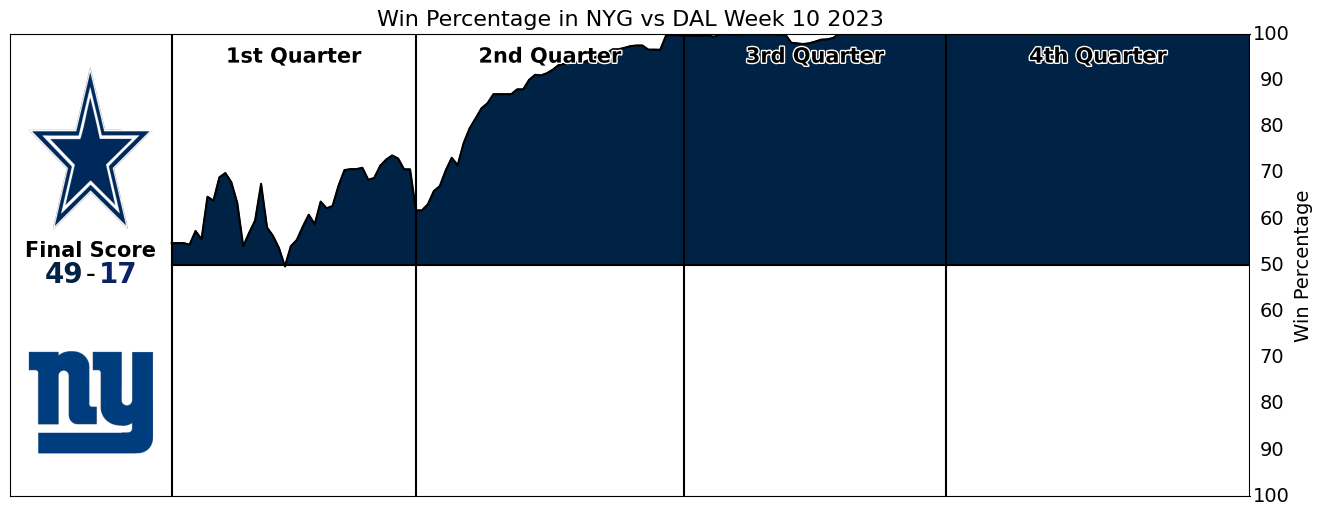

In [217]:
# Input data
tm1 = input("First Team: ").upper()
tm2 = input("Second Team: ").upper()
year = input("Season: ")

years = int(year)

game_ids = []
rev_game_ids = []
for wk in range(1,23):
  if (wk < 10):
    game_ids.append(f"{year}_0{wk}_{tm1}_{tm2}")
    rev_game_ids.append(f"{year}_0{wk}_{tm2}_{tm1}")

  else:
    game_ids.append(f"{year}_{wk}_{tm1}_{tm2}")
    rev_game_ids.append(f"{year}_{wk}_{tm2}_{tm1}")


game = nfl.import_pbp_data([years])

pd.set_option('display.max_columns', None)
gm_stats = game[["game_id", "home_team", "away_team","play_type", "drive", "qtr", "time", "home_wp","wp", "home_score", "away_score"]]


actual_game = gm_stats[gm_stats["game_id"] == game_ids[0]]

def div_teams():
  game_choice = input("Those teams are divisonal opponents and played twice in the regular season. Choose Matchup: Week " + f"{div1_wk}" + "(type 1)" + " or Week " + f"{div2_wk}" + "(type 2): ")
  if (game_choice == "1"):
    actual_game = gm_stats[gm_stats["game_id"] == f"{div1}"]
    wk = div1_wk
    home = tm2
  if (game_choice == "2"):
    actual_game = gm_stats[gm_stats["game_id"] == f"{div2}"]
    wk = div2_wk
    home = tm1

game_count = 0;

for i in range(0, len(game_ids)):

  temp_game = gm_stats[gm_stats["game_id"] == game_ids[i]]
  if (len(temp_game) != 0):
    actual_game = temp_game
    wk = i+1

    game_count += 1
    div1_wk = i+1
    div1 = game_ids[i]

    home = tm2

  temp_game = gm_stats[gm_stats["game_id"] == rev_game_ids[i]]
  if (len(temp_game) != 0):
    actual_game = temp_game
    wk = i+1

    game_count += 1
    div2_wk = i+1
    div2 = rev_game_ids[i]

    home = tm1

# WIP
if ((game_count > 1) & (wk > 18)):
  playoff_choice = input("Those teams played in the regular season and the playoffs. Do you want the playoff game (type 1) or regular season game (type 2): ")
  if (playoff_choice == "1"):
    actual_game = gm_stats[gm_stats["game_id"] == f"{div1}"]

  if (playoff_choice == "2"):
    actual_game = gm_stats[gm_stats["game_id"] == f"{div2}"]
    if (game_count == 3):
      div_teams()

elif (game_count == 2):
  div_teams()


wp = actual_game.reset_index(drop = True)

wp['play_num'] = range(len(wp))

wp.rename(columns= {"index": "play_num"},inplace= True)

wp["home_wp"] = wp["home_wp"] * 100
wp["play_num"] = wp["play_num"] / (len(wp)-1) * 200

wp_time = wp.sort_values(by = ["qtr","time"], ascending = [True, False]).reset_index(drop = True)

play_qtr = wp_time.groupby('qtr').last().reset_index()


# Team data
team = nfl.import_team_desc()

home_info = team[team["team_abbr"] == wp["home_team"][0]]
away_info = team[team["team_abbr"] == wp["away_team"][0]]

home_col = home_info["team_color"].values[0]
away_col = away_info["team_color"].values[0]


# GRAPHING
fig, ax = plt.subplots(figsize = (16,6))


# WP Graph
ax.plot(wp["play_num"], wp["home_wp"], color="k")
ax.fill_between(wp["play_num"], wp["home_wp"], y2=50, where=(wp["home_wp"] >= 50), color=home_col, alpha=1, interpolate=True)
ax.fill_between(wp["play_num"], wp["home_wp"], y2=50, where=(wp["home_wp"] < 50), color=away_col, alpha=1, interpolate=True)


# Even odds line
ax.plot([0, 200], [50, 50], color="k")


# Quarter Lines
ax.axvline(0, color="k")
for i in range(0,len(play_qtr)-1):
  ax.axvline(play_qtr["play_num"][i], color="k")
ax.axvline(200, color="k")

plt.text(play_qtr["play_num"][0] / 2, 95, "1st Quarter", fontsize=15, color="k", ha='center', va='center', weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground="w")])
plt.text(((play_qtr["play_num"][1]-play_qtr["play_num"][0]) / 2) + play_qtr["play_num"][0], 95, "2nd Quarter", fontsize=15, color="k", ha='center', va='center', weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground="w")])
plt.text(((play_qtr["play_num"][2]-play_qtr["play_num"][1]) / 2)+ play_qtr["play_num"][1], 95, "3rd Quarter", fontsize=15, color="k", ha='center', va='center', weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground="w")])
plt.text(((play_qtr["play_num"][3]-play_qtr["play_num"][2]) / 2) + play_qtr["play_num"][2], 95, "4th Quarter", fontsize=15, color="k", ha='center', va='center', weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground="w")])
if len(play_qtr) == 5:
  plt.text(((play_qtr["play_num"][4]-play_qtr["play_num"][3]) / 2) + play_qtr["play_num"][3], 95, "OT", fontsize=15, color="k", ha='center', va='center', weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground="w")])


# Final Score
plt.text(-15, 53, "Final Score", fontsize=15, color="k", ha='center', va='center', weight='bold')
plt.text(-20, 48, str(wp["home_score"][len(wp)-1]), fontsize=20, color=home_col, ha='center', va='center', weight='bold')
plt.text(-10, 48, str(wp["away_score"][len(wp)-1]), fontsize=20, color=away_col, ha='center', va='center', weight='bold')
plt.text(-15, 48, " - ", fontsize=20, color="k", ha='center', va='center')


# Labels
plt.ylim([0, 100])
plt.xlim([-30, 200])
plt.xticks([])
plt.yticks([])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
2
# WP Labels
for i in range(0,6):
    if i == 0:
      plt.text(204, 50, '50', fontsize=14, color="k", ha='center', va='center')
    else:
      plt.text(204, 50+10*i, f'{50+10*i}', fontsize=14, color="k", ha='center', va='center')
      plt.text(204, 50-10*i, f'{50+10*i}', fontsize=14, color="k", ha='center', va='center')
plt.text(210, 50, "Win Percentage", fontsize=14, color="k", ha='center', va='center', rotation=90)

# Title
ax.set_title("Win Percentage in " + tm1 + " vs " + tm2 + " Week " + str(wk) + " " + year, fontsize=16)


# Logo
home_logo_url = home_info["team_logo_espn"].values[0]
away_logo_url = away_info["team_logo_espn"].values[0]

home_logo_img = Image.open(urllib.request.urlopen(home_logo_url))
away_logo_img = Image.open(urllib.request.urlopen(away_logo_url))

ax.imshow(home_logo_img, extent=(-27, -3, 55, 95), aspect='auto', zorder=10)
ax.imshow(away_logo_img, extent=(-27, -3, 5, 35), aspect='auto', zorder=10)

ax.spines['right'].set_visible(False)

# Show Graph
plt.show()